<a href="https://colab.research.google.com/github/JianfengMI/MLprojects/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

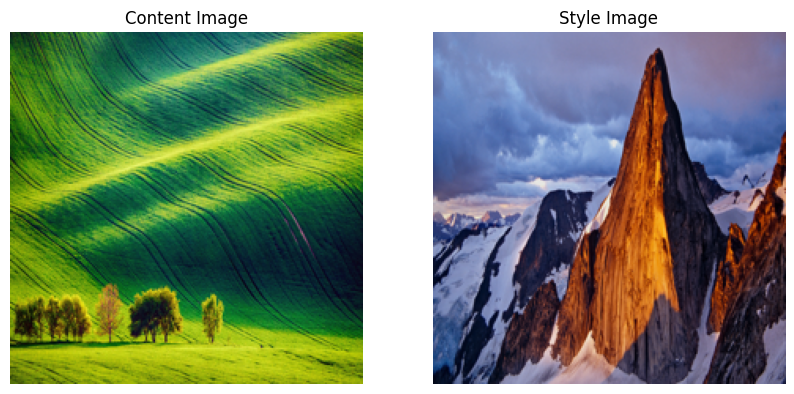

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Iteration 1/10, Loss: 789742813184.00
Iteration 2/10, Loss: 539784970240.00
Iteration 3/10, Loss: 405198962688.00
Iteration 4/10, Loss: 312077254656.00
Iteration 5/10, Loss: 242339840000.00
Iteration 6/10, Loss: 195071361024.00
Iteration 7/10, Loss: 164905189376.00
Iteration 8/10, Loss: 146344280064.00
Iteration 9/10, Loss: 133433483264.00
Iteration 10/10, Loss: 122486030336.00


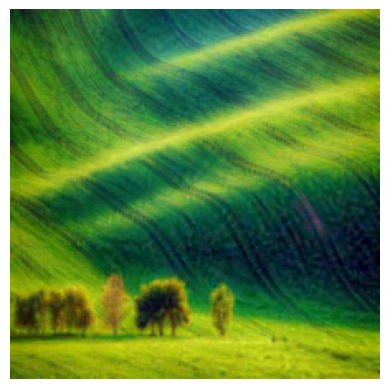

Generated image saved to generated.jpg


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# --- Utility Functions ---
def VGG16_AvgPool(shape):
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
    i = vgg.input
    x = i
    for layer in vgg.layers[1:]:
        if isinstance(layer, MaxPooling2D):
            x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
        else:
            x = layer(x)
    return Model(i, x)


def VGG16_AvgPool_Cutoff(shape, num_convs):
    model = VGG16_AvgPool(shape)
    n = 0
    output = None
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            n += 1
        if n >= num_convs:
            output = layer.output
            break
    return Model(model.input, output)


def gram_matrix(x):
    x = tf.transpose(x, (0, 3, 1, 2))   # (batch, channels, h, w)
    b, c, h, w = x.shape
    features = tf.reshape(x, (b, c, h * w))
    gram = tf.matmul(features, features, transpose_b=True)
    return gram / tf.cast(c * h * w, tf.float32)


def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB').resize(target_size)
    img_array = np.array(img).astype(np.float32)
    img_input = preprocess_input(img_array.copy())
    img_input = np.expand_dims(img_input, axis=0)
    return img_array, img_input


def content_loss(content, combination):
    return tf.reduce_sum(tf.square(combination - content))


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    return tf.reduce_sum(tf.square(S - C))


def total_variation_loss(x):
    a = tf.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = tf.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))


# --- Main Style Transfer ---
def style_transfer(content_path, style_path, output_path='generated.jpg', iterations=10,
                   content_weight=1e3, style_weight=1e-2, tv_weight=1e3):

    img_shape = (224, 224, 3)

    # Load images
    content_img, content_input = load_and_preprocess_image(content_path)
    style_img, style_input = load_and_preprocess_image(style_path)

    # Show input images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(content_img.astype(np.uint8))
    plt.title("Content Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(style_img.astype(np.uint8))
    plt.title("Style Image")
    plt.axis('off')
    plt.show()

    # Content and style models
    content_model = VGG16_AvgPool_Cutoff(img_shape, 11)
    style_layers = [1, 3, 6, 10]
    style_models = [VGG16_AvgPool_Cutoff(img_shape, l) for l in style_layers]

    # Extract features
    content_features = content_model(content_input)
    style_features = [m(style_input) for m in style_models]

    # Generated image variable
    generated = tf.Variable(content_input, dtype=tf.float32)

    # Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=5.0)

    # Optimization loop
    for i in range(iterations):
        with tf.GradientTape() as tape:
            c_out = content_model(generated)
            s_outs = [m(generated) for m in style_models]

            c_loss = content_weight * content_loss(content_features, c_out)
            s_loss = 0
            for sf, so in zip(style_features, s_outs):
                s_loss += style_weight / len(style_models) * style_loss(sf, so)
            tv_loss = tv_weight * total_variation_loss(generated)

            loss = c_loss + s_loss + tv_loss

        grads = tape.gradient(loss, generated)
        opt.apply_gradients([(grads, generated)])
        print(f"Iteration {i+1}/{iterations}, Loss: {loss.numpy():.2f}")

    # Deprocess image
    x = generated.numpy().squeeze()
    x = x + [103.939, 116.779, 123.68]   # add back mean
    x = x[:, :, ::-1]                    # BGR -> RGB
    x = np.clip(x, 0, 255).astype(np.uint8)

    plt.imshow(x)
    plt.axis('off')
    plt.savefig(output_path)
    plt.show()
    print(f"Generated image saved to {output_path}")

# Run style transfer
content_path = 'content.jpg'  # Replace with your content image path
style_path = 'style.jpg'      # Replace with your style image path
style_transfer(content_path, style_path, iterations=10)